### Install package and make imports:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# External
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Check data

In [3]:
apple_arr = np.load('/content/drive/MyDrive/Colab Notebooks/GANs project/data/apple.npy')
print(type(apple_arr))
print(apple_arr.shape)

<class 'numpy.ndarray'>
(144722, 784)


In [4]:
apple_arr = apple_arr.reshape(apple_arr.shape[0], 28, 28)

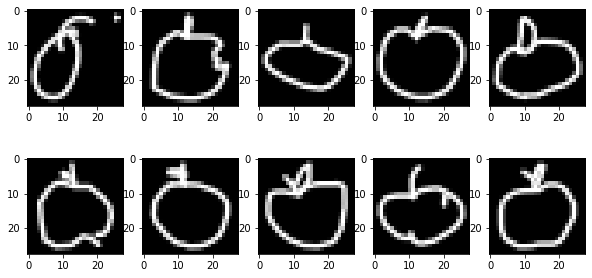

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
ax = ax.reshape(10)
for i in range(10):
    ax[i].imshow(apple_arr[i], cmap='gray')

### Construct model and ensure dimensions are right

In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam


In [7]:
def build_generator_test(start_filters, filter_size, latent_dim):

    def add_generator_block(x, filters, filter_size, strides=2):
        x = Conv2DTranspose(filters, filter_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.3)(x)
        return x

    inp = Input(shape=(latent_dim,))
    print(inp.shape)

    x = Dense(7 * 7 * (start_filters * 8), use_bias=False, input_shape=inp.shape)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(7, 7, start_filters * 8))(x)

    # design the generator to upsample the image 4x
    x = add_generator_block(x, start_filters * 4, filter_size, strides=1)
    x = add_generator_block(x, start_filters * 2, filter_size, strides=1)
    x = add_generator_block(x, start_filters, filter_size)
    x = add_generator_block(x, start_filters, filter_size)

    # turn the output into a 2D tensor, an image with 3 channels
    x = Conv2D(1, kernel_size=5, padding='same', activation='tanh')(x)

    return Model(inputs=inp, outputs=x)

In [8]:
def build_discriminator_test(start_filters, spatial_dim, filter_size):

    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size):
      #x = Conv2D(filters, filter_size, padding='same')(x)
      #x = BatchNormalization()(x)
      x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.3)(x)
      x = Dropout(0.3)(x)
      return x

    # input is an image with shape spatial_dim x spatial_dim and 1 channel
    inp = Input(shape=(28, 28, 1))

    # design the discrimitor to downsample the image 4x
    x = add_discriminator_block(inp, start_filters, filter_size)
    x = add_discriminator_block(x, start_filters * 2, filter_size)
    # x = add_discriminator_block(x, start_filters * 4, filter_size)
    # x = add_discriminator_block(x, start_filters * 8, filter_size)

    # average and return a binary output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    print(x.shape)

    return Model(inputs=inp, outputs=x)

In [16]:
# we will downscale the images
SPATIAL_DIM = 32
# size of noise vector
LATENT_DIM_GAN = 100
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 4
# batch size
BATCH_SIZE_GAN = 32
# interval for displaying generated images
PROGRESS_INTERVAL = 1000

In [17]:
def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator_test(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    # compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])

    ### generator
    # do not compile generator
    generator = build_generator_test(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)

    ### DCGAN
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])

    if verbose:
        generator.summary()
        discriminator.summary()
        gan.summary()

    return generator, discriminator, gan

In [18]:
generator, discriminator, gan = construct_models(verbose=False)

(None, 1)
(None, 100)


In [19]:
apple_norm = (apple_arr - 127.5) / 127.5

In [20]:
apple_norm.shape

(144722, 28, 28)

In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output

# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1
# number of generator updates per alternating training iteration
GEN_UPDATES = 3

TOTAL_SAMPLES = apple_arr.shape[0]

LOCAL_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/GANs project'

# function for training a GAN
def run_training(generator, discriminator, gan, start_it=0, num_epochs=1000, arr=apple_norm):

  # list for storing loss
  avg_loss_discriminator = []
  avg_loss_generator = []
  total_it = start_it

  # main training loop
  for epoch in range(num_epochs):

      # alternating training loop
      loss_discriminator = []
      loss_generator = []
      for it in range(200):

          #### Discriminator training loop ####
          for i in range(DISC_UPDATES):
              # select a random set of real images
              imgs_real = arr[np.random.randint(0, arr.shape[0], BATCH_SIZE_GAN)]
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # generate a set of fake images using the generator
              imgs_fake = generator.predict(noise)
              # train the discriminator on real images with label 1
              d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
              # train the discriminator on fake images with label 0
              d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]

          # display some fake images for visual control of convergence
          if total_it % PROGRESS_INTERVAL == 0:
              plt.figure(figsize=(5,2))
              num_vis = min(BATCH_SIZE_GAN, 5)
              imgs_real = arr[np.random.randint(0, arr.shape[0], BATCH_SIZE_GAN)]
              noise = np.random.randn(num_vis, LATENT_DIM_GAN)
              imgs_fake = generator.predict(noise)
              for obj_plot in [imgs_fake, imgs_real]:
                  plt.figure(figsize=(num_vis * 3, 3))
                  for b in range(num_vis):
                      disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                      plt.subplot(1, num_vis, b + 1)
                      plt.title(str(round(disc_score, 3)))
                      plt.imshow(obj_plot[b].reshape(28, 28) * 0.5 + 0.5, cmap='gray')
                  if obj_plot is imgs_fake:
                      plt.savefig(os.path.join(LOCAL_DATA_PATH + '/visualization', str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                  plt.show()

          #### Generator training loop ####
          loss = 0
          y = np.ones([BATCH_SIZE_GAN, 1])
          for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
              loss += gan.train_on_batch(noise, y)[1]

          # store loss
          loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)
          loss_generator.append(loss / GEN_UPDATES)
          total_it += 1

      # visualize loss
      clear_output(True)
      print('Epoch', epoch)
      avg_loss_discriminator.append(np.mean(loss_discriminator))
      avg_loss_generator.append(np.mean(loss_generator))
      plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
      plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
      plt.legend(['discriminator loss', 'generator loss'])
      plt.show()

  return generator, discriminator, gan


Epoch 3


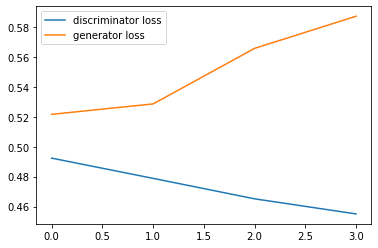

1/1 [==============================] - 0s 32ms/step


KeyboardInterrupt: ignored

In [23]:
gen_tr, disc_tr, gan_tr = run_training(generator, discriminator, gan, start_it=0, num_epochs=50, arr=apple_arr)